# RecurrentTao - Generating Chinese Philosophy using RNNs
Advances in recurrent neural nets has enhanced the ability for machines to construct sentences by learning from reference material. This notebook applies these techniques on an english translation of Tao Te Ching - the famous philosophical text for Taoism.

In [1]:
# Standard libraries
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Data Preparation
The text is fairly clean but we will run a number of preprocessing methods before exploring the dataset first.

1. Loading the book as a long string.
2. Remove characters that are not letters or standard punctuation.
3. Produce a list of classes consisting of all the distinct characters after cleansing. This is required for encoding each character as numeric.

In [2]:
with open('taoteching_windows.txt') as f:
    x = f.read()
    
print(x)

Tao Te Ching
Chapter One
Tao (The Way) that can be spoken of is not the Constant Tao’
The name that can be named is not a Constant Name.
Nameless, is the origin of Heaven and Earth;
The named is the Mother of all things.
Thus, the constant void enables one to observe the true essence.
The constant being enables one to see the outward manifestations.
These two come paired from the same origin.
But when the essence is manifested,
It has a different name.
This same origin is called “The Profound Mystery.”
As profound the mystery as It can be,
It is the Gate to the essence of all life.
Chapter Two
As soon as beauty is known by the world as beautiful, it becomes ugly.
As soon as virtue is being known as something good, it becomes evil.
Therefore being and non-being give birth to each other.
Difficult and easy accomplish each other.
Long and short form each other.
High and low distinguish each other.
Sound and tone harmonize each other
Before and after follow each other as a sequence.
Realiz

In [3]:
x = x.replace('\n', ' ')
x = x.replace('\r', ' ')
x = x.replace('  ', ' ')
x = x.lower()
import re

def cleaned_text(text):
    return re.sub("[^!,.:;? a-zA-Z]", "", text)

text = cleaned_text(x)

chars = sorted(list(set(text)))
print("this corpus has " + str(len(text)) + " total number of characters")
print("this corpus has " + str(len(chars)) + " unique characters")
print(chars)

this corpus has 54061 total number of characters
this corpus has 33 unique characters
[' ', '!', ',', '.', ':', ';', '?', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


## Exploratory Analysis
We can begin to visualize the types of words that feature in the text most frequently as insight to what words the RNN model might choose. We can start simple with an n-gram approach to model generation by randomly selecting subsequent words from a list of possible options derived from the text.

1. Generate frequencies of words.
2. Create frequencies of bigrams/trigrams/n-grams.
3. Build simple n-gram prediction model.
4. Generate sentences from this example.

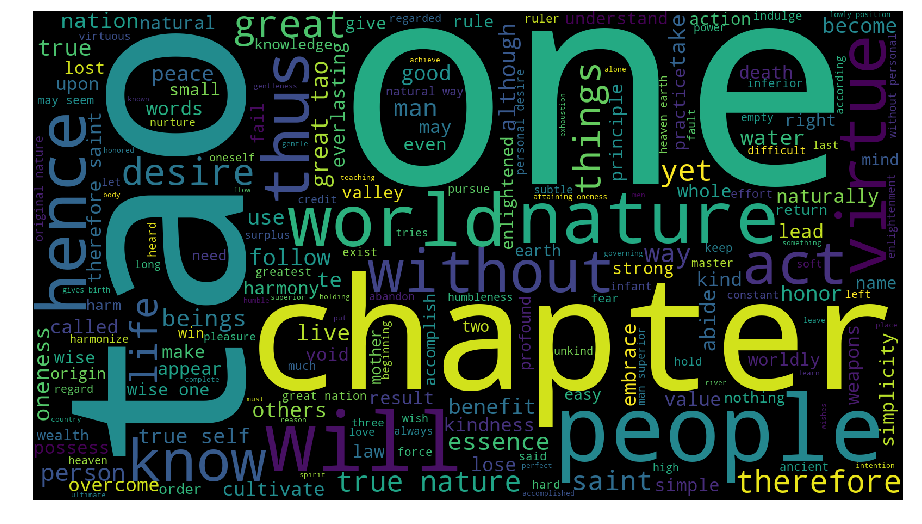

In [4]:
from wordcloud import WordCloud, STOPWORDS

wordcloud = WordCloud(width=1600, height=900, stopwords=STOPWORDS).generate(text)
plt.figure(figsize=(16,9))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [5]:
from collections import Counter

word_split = text.split(' ')
word_count = Counter(word_split)
word_df = pd.DataFrame([[k,v] for k,v in word_count.items()], columns=['word', 'frequency'])
non_stopwords = word_df.query('word not in @STOPWORDS')
non_stopwords.nlargest(100, columns = ['frequency'])

,word,frequency
4,one,113
0,tao,81
3,chapter,81
150,will,63
149,people,62
32,true,57
312,great,54
193,nature,53
110,ones,48
103,without,43


In [6]:
# Given a piece of text and n, construct the n-grams
def create_ngrams(text, n):
    word_split = text.split(' ')
    if n >= len(text):
        raise Exception('Sequence is too large.')
    grams = len(word_split) - n
    n_grams = [tuple(word_split[i:i+n]) for i in range(grams)]
    
    return n_grams

In [7]:
# Create bigrams and trigrams to see what sequences are common
bigrams = create_ngrams(text, 2)
trigrams = create_ngrams(text, 3)

bigram_counter = Counter(bigrams)
trigram_counter = Counter(trigrams)
bigram_counter.most_common(20)

[(('of', 'the'), 59),
 (('to', 'be'), 54),
 (('it', 'is'), 51),
 (('with', 'the'), 46),
 (('is', 'the'), 44),
 (('does', 'not'), 40),
 (('he', 'who'), 35),
 (('to', 'the'), 31),
 (('he', 'is'), 25),
 (('the', 'great'), 25),
 (('one', 'who'), 25),
 (('the', 'world'), 24),
 (('will', 'not'), 24),
 (('is', 'to'), 24),
 (('those', 'who'), 24),
 (('this', 'is'), 24),
 (('there', 'is'), 22),
 (('is', 'not'), 21),
 (('the', 'saint'), 20),
 (('tao', 'is'), 20)]

In [8]:
from collections import defaultdict
import random

# Generate random sequences based on the grams
def create_transition(ngram):
    n = len(ngram[0])
    transitions = defaultdict(list)
    for gram in ngram:
        transitions[gram[:-1]].append(gram[-1])
    
    return transitions

def generate_sentences(ngrams, transitions, words_to_generate):
    words = [list(random.choice(ngrams, 1)).split()]

## Preparing Sequence Windows

In [9]:
def windowFunction(text, window_size = 2, step_size = 2):
    steps = (len(text) - window_size) // step_size
    input_window = [text[(i*step_size):(i*step_size)+window_size] for i in range(steps)]
    output_window = [text[(i*step_size)+window_size] for i in range(steps)]
    
    return input_window, output_window

In [10]:
X, y = windowFunction(text, 20)

print("input:", X[11])
print("output:", y[11])
print('-------------')
print("input:", X[100])
print("output:", y[100])

input: ne tao the way that 
output: c
-------------
input: er of all things. th
output: u


In [11]:
chars_to_indices = dict((c, i) for i, c in enumerate(chars))
indices_to_chars = dict((i, c) for i, c in enumerate(chars))

In [12]:
# transform characters to numerical versions
def encode_io_pairs(text, window_size, step_size):
    input_seq, output_seq = windowFunction(text, window_size, step_size)
    
    X = np.zeros(shape=(len(input_seq), window_size, len(chars_to_indices)), dtype=np.bool)
    y = np.zeros(shape=(len(output_seq), len(chars_to_indices)))
    
    for i, sentence in enumerate(input_seq):
        for t, char in enumerate(sentence):
            X[i,t,chars_to_indices[char]] = 1
        y[i, chars_to_indices[output_seq[i]]] = 1
        
    return X, y

In [13]:
window_size = 100
step_size = 1

X, y = encode_io_pairs(text, window_size, step_size)
print(X.shape)
print(y.shape)

(53961, 100, 33)
(53961, 33)


## RNN - LSTM Variant

In [14]:
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
import keras
import random

Using TensorFlow backend.


In [16]:
def build_model(recurrent, units):
    model = Sequential()
    model.add(recurrent(units, input_shape = (window_size, len(chars))))
    model.add(Dense(len(chars)))
    model.add(Activation(activation='softmax'))
    
    return model

lstm_model = build_model(LSTM, 200)

optimizer = keras.optimizers.RMSprop(lr=0.001, rho = 0.9, epsilon=1e-08, decay=0)
lstm_model.compile(loss='categorical_crossentropy', optimizer = optimizer, metrics = ['acc'])

In [18]:
Xsmall = X[:10000,:,:]
ysmall = y[:10000,:]

lstm_model.fit(Xsmall, ysmall, batch_size=1024, epochs=40, verbose=1)
lstm_model.save_weights('best_RNN_small.hdf5')

Epoch 1/40
10000/10000 [==============================] - 3s - loss: 1.6740 - acc: 0.5059     
Epoch 2/40
10000/10000 [==============================] - 3s - loss: 1.6486 - acc: 0.5105     
Epoch 3/40
10000/10000 [==============================] - 3s - loss: 1.6138 - acc: 0.5219     
Epoch 4/40
10000/10000 [==============================] - 3s - loss: 1.5950 - acc: 0.5263     
Epoch 5/40
10000/10000 [==============================] - 3s - loss: 1.5678 - acc: 0.5318     
Epoch 6/40
10000/10000 [==============================] - 3s - loss: 1.5512 - acc: 0.5388     
Epoch 7/40
10000/10000 [==============================] - 3s - loss: 1.5310 - acc: 0.5459     
Epoch 8/40
10000/10000 [==============================] - 3s - loss: 1.4995 - acc: 0.5557     
Epoch 9/40
10000/10000 [==============================] - 3s - loss: 1.4813 - acc: 0.5619     
Epoch 10/40
10000/10000 [==============================] - 3s - loss: 1.4588 - acc: 0.5678     
Epoch 11/40
10000/10000 [========================

In [21]:
# Given an input sequence, predict the next number of characters using the trained RNN model.
def predict_next_chars(model, input_chars, num_to_predict):
    predicted_chars = ''
    for i in range(num_to_predict):
        x_test = np.zeros((1, window_size, len(chars)))
        for t, char in enumerate(input_chars):
            x_test[0, t, chars_to_indices[char]] = 1
        
        test_predict = model.predict(x_test, verbose = 0)[0]
        
        r = np.argmax(test_predict)
        d = indices_to_chars[r]
        
        predicted_chars += d
        input_chars += d
        input_chars = input_chars[1:]
    return predicted_chars            

In [26]:
start_inds = [100, 200, 300, 400, 500]
lstm_model.load_weights('best_RNN_small.hdf5')

# Given an array of start indices from the text and a model, print out all the predicted sequences
def predict_sequences(model, start_inds):
    for s in start_inds:
        start_index = s
        input_chars = text[start_index:start_index + window_size]
        predict_input = predict_next_chars(model, input_chars, num_to_predict = 100)
        
        print('-------------------')
        input_line = 'input chars = "' + input_chars + '"'
        print(input_line)
        line = 'predicted chars = "' + predict_input + '"'
        print(line)
        
predict_sequences(lstm_model, start_inds)

-------------------
input chars = " be named is not a constant name. nameless, is the origin of heaven and earth; the named is the moth"
predicted chars = "er one to erter. chapter ther enentunane s archist of the mystic taoune wale soncoust of the mord is"
-------------------
input chars = "er of all things. thus, the constant void enables one to observe the true essence. the constant bein"
predicted chars = "g enables one to ses reao. the eapte seact of the misterion all things without the ores not calles t"
-------------------
input chars = "g enables one to see the outward manifestations. these two come paired from the same origin. but whe"
predicted chars = "n the essence of the sulle is the mayter in the resert of the misterion all things without the ores "
-------------------
input chars = "n the essence is manifested, it has a different name. this same origin is called the profound myster"
predicted chars = "y gover and furce. the gave to sherf call the mastingion. a harsone th

In [21]:
# Fit the LSTM model on the entire dataset.
lstm_model.fit(X, y, batch_size = 1024, epochs = 40, verbose = 1)
lstm_model.save_weights('best_RNN_full.hdf5')

Epoch 1/40
53962/53962 [==============================] - 20s - loss: 1.5997 - acc: 0.5338    
Epoch 2/40
53962/53962 [==============================] - 19s - loss: 1.4968 - acc: 0.5584    
Epoch 3/40
53962/53962 [==============================] - 19s - loss: 1.4455 - acc: 0.5746    
Epoch 4/40
53962/53962 [==============================] - 19s - loss: 1.4070 - acc: 0.5859    
Epoch 5/40
53962/53962 [==============================] - 19s - loss: 1.3731 - acc: 0.5956    
Epoch 6/40
53962/53962 [==============================] - 19s - loss: 1.3411 - acc: 0.6055    
Epoch 7/40
53962/53962 [==============================] - 19s - loss: 1.3114 - acc: 0.6153    
Epoch 8/40
53962/53962 [==============================] - 19s - loss: 1.2841 - acc: 0.6245    
Epoch 9/40
53962/53962 [==============================] - 19s - loss: 1.2556 - acc: 0.6322    
Epoch 10/40
53962/53962 [==============================] - 20s - loss: 1.2268 - acc: 0.6419    
Epoch 11/40
53962/53962 [========================

In [25]:
start_inds = [100, 200, 300, 400, 500]
f = open('RNN_output.txt', 'w')

lstm_model.load_weights('best_RNN_full.hdf5')
predict_sequences(lstm_model, start_inds)

-------------------
input chars = " be named is not a constant name. nameless, is the origin of heaven and earth; the named is the moth"
predicted chars = "er of all things. therefore, the greate the great is calling and the surtle of tao. chapter thirtysi"
-------------------
input chars = "er of all things. thus, the constant void enables one to observe the true essence. the constant bein"
predicted chars = "g enables one to see the outhalt as are fullound. therefore, the saint a waids and shall wis the tao"
-------------------
input chars = "g enables one to see the outward manifestations. these two come paired from the same origin. but whe"
predicted chars = "n the essence is sumplientian ones endies take be the fealor. the sait form with the sult rate to be"
-------------------
input chars = "n the essence is manifested, it has a different name. this same origin is called the profound myster"
predicted chars = "y. a man of superior virtue, a person of nature without desire while h

## GRU Variant

In [17]:
from keras.layers import GRU, SimpleRNN

# Train the equivalent model but using a Gated Recurrent Unit instead.
gru_model = build_model(GRU, 200)
optimizer = keras.optimizers.RMSprop(lr=0.001, rho = 0.9, epsilon=1e-08, decay=0)
gru_model.compile(loss='categorical_crossentropy', optimizer = optimizer, metrics = ['acc'])
gru_model.fit(X, y, batch_size=1024, epochs=40, verbose=1)

Epoch 1/40
41984/53961 [======================>.......] - ETA: 1:06 - loss: 3.0126 - acc: 0.1733

KeyboardInterrupt: 

## Simple RNN Variant

In [ ]:
rnn_model = build_model(SimpleRNN, 200)
optimizer = keras.optimizers.RMSprop(lr=0.001, rho = 0.9, epsilon=1e-08, decay=0)
rnn_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])
rnn_model.fit(X, y, batch_size= 1024, epochs=40, verbose=1)